In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import pickle

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tmu.models.classification.vanilla_classifier import TMClassifier
from src.lib.care import calculate_care_score

In [176]:
# Create folder figures_1 if it does not exist
os.makedirs("figures", exist_ok=True)

In [177]:
def load_test_dataset(farm, event_id):
    X = np.loadtxt(f"./data_test/X_{farm}_{event_id}.txt", dtype=np.uint32)
    X = np.array(X).astype(np.uint32)

    # Take the first 3000 rows
    #X = X[:3000]

    return X


def load_test_labels(farm, event_id):
    # Load dataframe from file
    df = pd.read_csv(f"./data_test/y_{farm}_{event_id}.csv")

    labels = df['label'].values
    status_ids = df['status_type_id'].values
    train_test = df['train_test'].values

    # Take the first 3000 rows
    #labels = labels[:3000]
    #status_ids = status_ids[:3000]
    #train_test = train_test[:3000]

    return np.array(labels).astype(np.uint32), np.array(status_ids).astype(np.uint32), train_test


def load_test_label(farm, event_id):
    event_info = pd.read_csv(f"../../../data/care_to_compare/Wind Farm {farm}/event_info.csv", delimiter=';')

    metadata = event_info[event_info['event_id'] == event_id]

    event_label = metadata["event_label"].values[0]

    return False if event_label == "anomaly" else True

In [178]:
def calculate_accuracy(labels, predictions):
    # Calculate the accuracy
    accuracy = np.sum(labels == predictions) / len(labels)
    return accuracy

In [179]:
def load_model(filename) -> TMClassifier:
    with open(filename, "rb") as f:
        model = pickle.load(f)

    return model

In [180]:
def plot_predictions(X, y, z, p, name):
    cmap = plt.colormaps['RdBu']

    x = np.arange(0, len(X))  # Time or index

    y_mapped = np.where(y == 0, -0.2, -0.1)
    p_mapped = np.where(p == 0, 0, 0.1)

    # Create a single plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot all data on the single plot
    ax.plot(x, p_mapped, label="Predicted anomalies", alpha=0.7, color=cmap(0.1))
    ax.plot(x, y_mapped, label="Actual Anomalies (y)", color=cmap(0.8), linestyle='-', linewidth=2)

    # Add horizontal reference lines
    ax.axhline(y=0.1, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    ax.axhline(y=-0.1, color='black', linestyle='dotted', linewidth=1, alpha=0.5)
    ax.axhline(y=-0.2, color='black', linestyle='dotted', linewidth=1, alpha=0.5)

    # Set plot labels and limits
    ax.set_title("Anomalies and Reconstruction Loss")
    ax.set_xlabel("Time")
    ax.set_ylabel("Values")
    ax.set_ylim(-0.3, 0.3)
    ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.grid(True)

    # plt.show()

    # Save the plot
    plt.savefig(f"./figures/plot_detections_{name}.pdf")

    plt.close()


def plot_matrix(y, p, name):
    cm = confusion_matrix(y, p)

    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (dataset {name})')

    # Save the plot
    plt.savefig(f"./figures/plot_matrix_{name}.pdf")
    plt.close()


def get_predictions(X, y, z, name, tm):
    X_predictions = tm.predict(X)

    # Accuracy
    accuracy = calculate_accuracy(y, X_predictions)

    plot_predictions(X, y, z, X_predictions, name)
    plot_matrix(y, X_predictions, name)

    return X_predictions, accuracy

In [181]:
wind_farm = "A"
test_datasets = [25, 69, 13, 24, 3, 17, 38, 71, 14, 92, 51]

tm_classifier = load_model("models/best.pkl")


def run_prediction(farm, dataset):
    X = load_test_dataset(farm, dataset)
    labels, status_ids, train_test = load_test_labels(farm, dataset)

    is_normal = load_test_label(farm, dataset)

    predictions, accuracy = get_predictions(X, labels, status_ids, f"{farm}_{dataset}", tm_classifier)

    return X, labels, status_ids, train_test, is_normal, predictions, accuracy


In [182]:
# Create a dataframe with status_type_id;label;prediction
elements = []

for set in test_datasets:
    res = run_prediction(wind_farm, set)

    result_df = pd.DataFrame({
        'status_type_id': res[2],
        'label': res[1],
        'prediction': res[5],
        'train_test': res[3],
    })

    print(f"Done with {set}. Accuracy: {res[6]}")

    elements.append({'dataset': set, 'normal': res[4], 'data': result_df, 'accuracy': res[6]})

2025-04-18 22:29:09,694 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/System/Library/Fonts/Supplemental/Arial.ttf'
2025-04-18 22:29:09,743 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
2025-04-18 22:29:09,744 - matplotlib.backends.backend_pdf - DEBUG - Writing TrueType font.
2025-04-18 22:29:09,956 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/System/Library/Fonts/Supplemental/Arial.ttf'
2025-04-18 22:29:09,979 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /System/Library/Fonts/Supplemental/Arial.ttf.
2025-04-18 22:29:09,979 - matplotlib.backends.backend_pdf - DEBUG - Writing TrueType font.
Done with 68. Accuracy: 0.7084967320261438
2025-04-18 22:29:10,328 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/System/Library/Fonts/Supplemental/Arial.ttf'
2025-04-18 22:29:10,362 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /System/Library/Fonts/Supp

In [183]:
# Safe the results to results.pkl
with open("results.pkl", "wb") as f:
    pickle.dump(elements, f)

In [184]:
score = calculate_care_score(elements)
print(score)

ZeroDivisionError: float division by zero

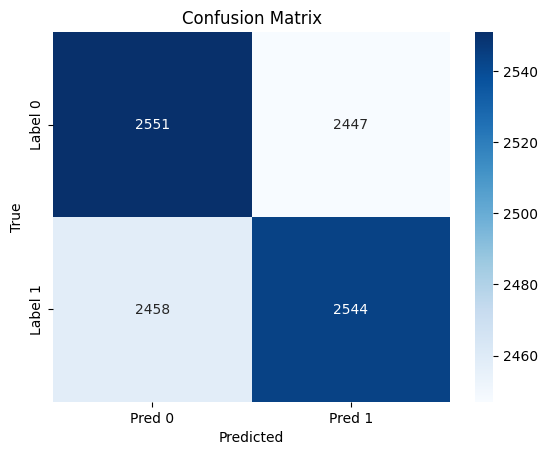